In [2]:
import os
import pandas

mirna_src_dir = os.getcwd() + "/data/processed/miRNA/"
clinical_src_dir = os.getcwd() + "/data/processed/clinical/"

mirna_tumor_df = pandas.read_csv(mirna_src_dir+'tumor_miRNA.csv')
mirna_normal_df = pandas.read_csv(mirna_src_dir+'normal_miRNA.csv')
clinical_df = pandas.read_csv(clinical_src_dir+'clinical.csv')

print "mirna_tumor_df.shape", mirna_tumor_df.shape
print "mirna_normal_df.shape", mirna_normal_df.shape

"""
Here we select samples to use for our regression analysis
"""
matched_samples = pandas.merge(clinical_df, mirna_normal_df, on='patient_barcode')['patient_barcode']
# print "matched_samples", matched_samples.shape
# merged = pandas.merge(clinical_df, mirna_tumor_df, on='patient_barcode')
# print merged.shape
# print
# print merged['histological_type'].value_counts().sort_index(axis=0)
# print
# print merged['pathologic_stage'].value_counts().sort_index(axis=0)
# print
# print merged['pathologic_T'].value_counts().sort_index(axis=0)
# print
# print merged['pathologic_N'].value_counts().sort_index(axis=0)
# print
# print merged['pathologic_M'].value_counts().sort_index(axis=0)
# print

mirna_tumor_df.shape (513, 1882)
mirna_normal_df.shape (46, 1882)


## We now create data matrixes from tumor vs normal samples

In [3]:
from sklearn import preprocessing
import numpy as np
X_normal = mirna_normal_df[mirna_normal_df['patient_barcode'].isin(matched_samples)]
X_tumor = mirna_tumor_df[mirna_tumor_df['patient_barcode'].isin(matched_samples)]
X_normal.__delitem__('patient_barcode')
X_tumor.__delitem__('patient_barcode')

X = pandas.concat([X_normal, X_tumor])
# Create labels for 92 samples, first 46 labeled 0 indicating normal tissues, and last 46 labeled 1 for tumor tissues
Y = np.concatenate((-np.ones(46), np.ones(46)), axis=0)

# print 'miRNA null values', X.isnull().sum().sum()
# print 'Y null values', Y.isnull().sum()

print "X_normal.shape", X_normal.shape
print "X_tumor.shape", X_tumor.shape
print "Y.shape", Y.shape

mirna_list = X.columns.values
# 
X_scaler = preprocessing.StandardScaler(with_mean=False).fit(X)
X = X_scaler.transform(X)

X_normal.shape (46, 1881)
X_tumor.shape (46, 1881)
Y.shape (92,)


## Perform classification with an L1-regularized Logistic Regression

In [18]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=np.random.randint(0, 10000))
print 'X_train', X_train.shape, ', y_train', y_train.shape
print 'X_test', X_test.shape, ', y_test', y_test.shape

model = linear_model.LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-10, 10))),
                                          penalty="l1",
                                          scoring='roc_auc',
                                          solver='liblinear',
                                          fit_intercept=False, 
                                          verbose=0)
model.fit(X_train, y_train)
print model
non_zero_idx = np.nonzero(model.coef_.ravel())[0]
print "\nNon-zero coef:", non_zero_idx.size
df = pandas.DataFrame({"mirna": mirna_list[non_zero_idx],
                       "coefficient": model.coef_.ravel()[non_zero_idx]})
print df.sort(columns='coefficient', ascending=False).head(5)
print df.sort(columns='coefficient', ascending=True).head(5)

print "\nClassification_report on training"
print metrics.classification_report(y_train, model.predict(X_train), labels=[-1, 1], target_names=["normal", "tumor"])
print "classification_report on testing"
print metrics.classification_report(y_test, model.predict(X_test), labels=[-1, 1], target_names=["normal", "tumor"])
print metrics.confusion_matrix(y_test, model.predict(X_test), labels=[-1, 1])

X_train (73, 1881) , y_train (73,)
X_test (19, 1881) , y_test (19,)


LogisticRegressionCV(Cs=[1e-10, 1.0000000000000001e-09, 1e-08, 9.9999999999999995e-08, 9.9999999999999995e-07, 1.0000000000000001e-05, 0.0001, 0.001, 0.01, 0.10000000000000001, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0, 1000000000.0],
           class_weight=None, cv=None, dual=False, fit_intercept=False,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l1', random_state=None, refit=True,
           scoring='roc_auc', solver='liblinear', tol=0.0001, verbose=0)

Non-zero coef: 813
     coefficient           mirna
466     0.606447    hsa-mir-4789
14      0.513651   hsa-mir-105-2
125     0.452728  hsa-mir-196a-1
360     0.425223    hsa-mir-449a
505     0.408502    hsa-mir-5092
     coefficient            mirna
673    -0.646503     hsa-mir-6757
20     -0.513789      hsa-mir-1-1
157    -0.476102    hsa-mir-218-2
386    -0.370630     hsa-mir-4655
333    -0.367880  hsa-mir-4436b-1

Classification_report on t

/Users/jonny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/jonny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [20]:
print ('Max auc_roc:', model.scores_[1])

('Max auc_roc:', array([[ 0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.94230769,
         0.94230769,  0.93589744,  0.98717949,  1.        ,  1.        ,
         1.        ,  0.98717949,  0.96794872,  0.92307692,  0.96153846],
       [ 0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ,  0.5       ,  0.5       ,  0.5       ,  1.        ,
         1.        ,  0.98717949,  1.        ,  1.        ,  1.        ,
         1.        ,  0.98717949,  0.99358974,  1.        ,  1.        ],
       [ 0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.92424242,
         0.93181818,  0.90909091,  0.96212121,  0.99242424,  1.        ,
         1.        ,  1.        ,  0.96969697,  0.96212121,  0.98484848]]))


In [21]:
from matplotlib import pyplot as plt
# Display results
m_log_alphas = model.Cs_

plt.figure()
plt.plot(m_log_alphas, model.scores_[1], ':')
plt.plot(m_log_alphas, model.scores_[1].mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')
plt.show()

ValueError: x and y must have same first dimension

In [5]:
print y_test[0:7]
print np.inner(model.coef_, X_test[0:7])

[-1. -1. -1.  1. -1. -1. -1.]
[[-2.28115571 -1.6575392  -1.75741252  0.04888271 -2.11033854 -2.48848502
  -3.75204913]]


In [6]:
print "classification_report on rest of tumor patients"
X_tumor_unmatched = mirna_tumor_df[~mirna_tumor_df['patient_barcode'].isin(matched_samples)].dropna(subset=['hsa-mir-96']).copy()
X_tumor_unmatched.__delitem__('patient_barcode')
X_tumor_unmatched = X_scaler.transform(X_tumor_unmatched)
print X_tumor_unmatched.shape

Y_tumor_unmatched = np.array([1,]*X_tumor_unmatched.shape[0], dtype=int)

print metrics.classification_report(Y_tumor_unmatched, model.predict(X_tumor_unmatched), labels=[-1, 1], target_names=["normal", "target"])
print metrics.confusion_matrix(Y_tumor_unmatched, model.predict(X_tumor_unmatched), labels=[-1, 1])

classification_report on rest of tumor patients
(467, 1881)
             precision    recall  f1-score   support

     normal       0.00      0.00      0.00         0
     target       1.00      0.96      0.98       467

avg / total       1.00      0.96      0.98       467

[[  0   0]
 [ 19 448]]


/Users/jonny/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Try to draw a LASSO path

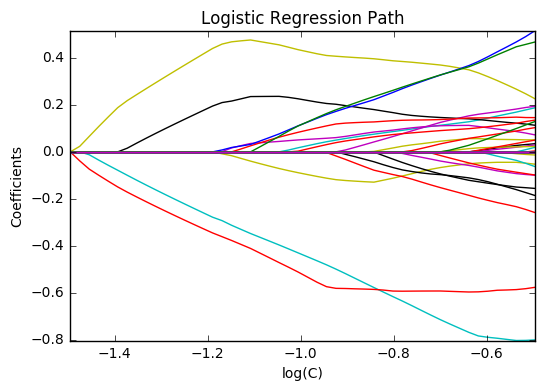

In [10]:
from sklearn.svm import l1_min_c
from matplotlib import pyplot as plt

cs = l1_min_c(X, Y, loss='log') * np.logspace(0, 1)
clf = linear_model.LogisticRegression(C=0.1, penalty='l1', tol=1e-6)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, Y)
    coefs_.append(clf.coef_.ravel().copy())

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_)
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()

In [8]:
from matplotlib import pyplot as plt
from itertools import cycle

colors = cycle(['r', 'b', 'g', 'c', 'k', 'm', 'y', '0.75', '#1985a0'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)

for coef_l, c in zip(coefs_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso ')
plt.axis('tight')
plt.show()

NameError: name 'alphas_lasso' is not defined